In [13]:
%matplotlib inline

from helper_function1 import *
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
import pickle
from IPython.display import display
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import io

from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import binary_dilation, grey_dilation

'../video_images/test001.jpg'

(720, 1280, 3)


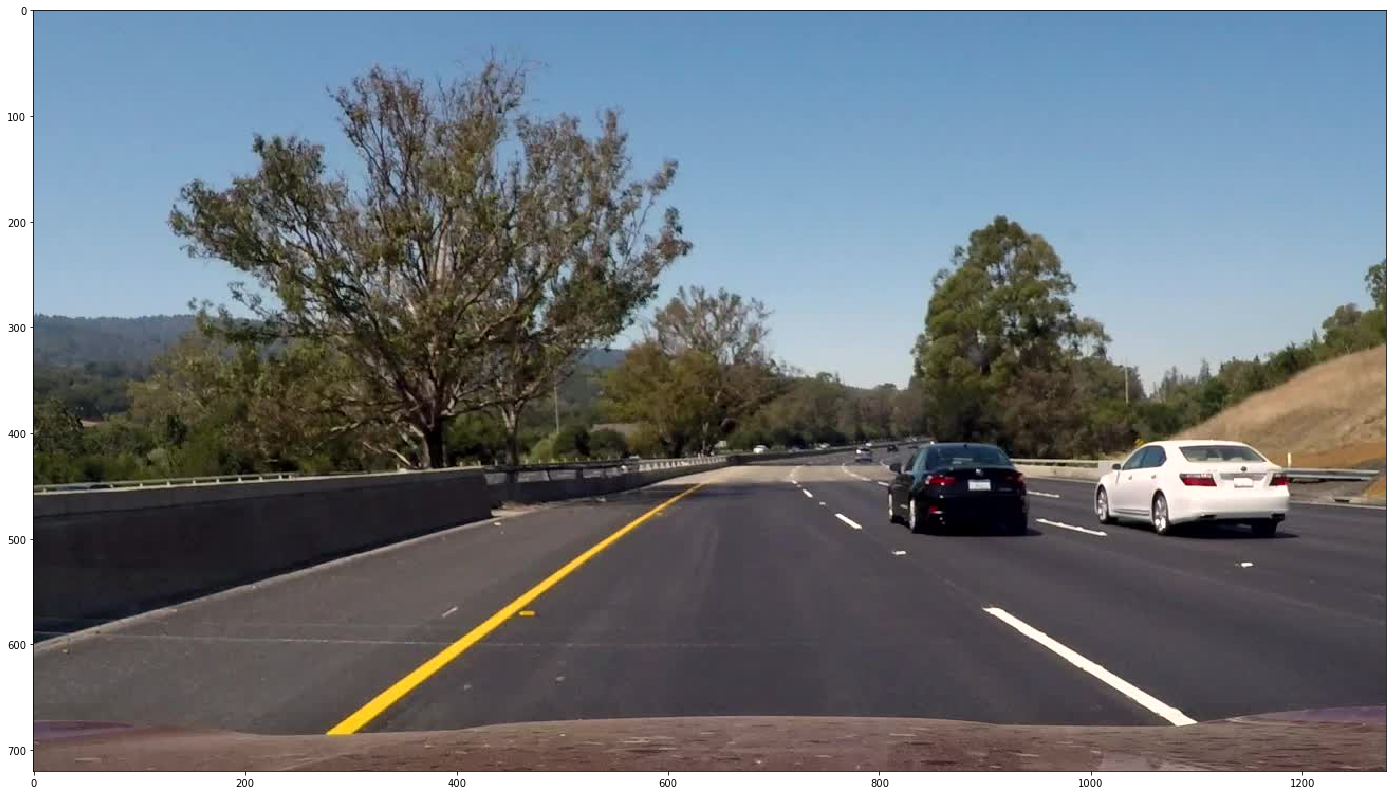

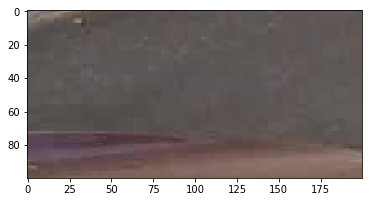

In [14]:
#test_img="output_frames/40.png"
test_img="../video_images/test001.jpg"

display(test_img)
img=mpimg.imread(test_img)
plt.figure(figsize=(25,14))
plt.imshow(img)
print(img.shape)

plt.figure()
plt.imshow(img[600:700, 0:200])

In [15]:
# Load trained classifier 

clf = pickle.load(open('trained_classifier.pkl', 'rb'))
print(clf)
X_scaler = pickle.load(open('x_scaler.pkl', 'rb'))
pca = pickle.load(open('pca.pkl', 'rb'))

LinearSVC(C=0.00016681005372000591, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)


Temp window size  4396
Temp window size  924
Temp window size  148
Temp window size  0
Final window size:  5468


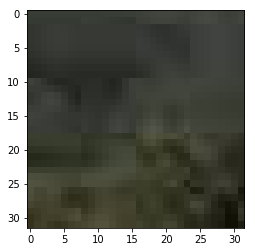

In [16]:
# Extract segments from image

y_start_stop = [350, 600] # Min and max in y to search in slide_window()

#output format ((startx, starty), (endx, endy))
xy_windows = [[32,32], [64,64], [128,128], [256, 256]]
#xy_windows = [[64,64], [128,128], [256, 256]]
#xy_windows = [[100,100]]

#xy_windows = [[128,128]]
#xy_windows = [[64, 64]]

xy_overlap = [0.75,0.75]
#xy_overlap = [0.5,0.5]
windows = []
for xy_window in xy_windows:
    tmp_window = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    print("Temp window size ", len(tmp_window))
    windows = windows + tmp_window
    
print("Final window size: ", len(windows))
first = windows[0]
plt.imshow(img[first[0][1]:first[1][1], first[0][0]:first[1][0]])

In [17]:
selected_windows = []


for window in windows:
    image_window = extract_image_window(img, window)
    # Resize it to 64x64
    image_window = cv2.resize(image_window, (64,64))
    image_features = extract_features_for_one_image(image_window)
    #print(image_features.shape)
    image_features = image_features.reshape(1, -1)
    scaled_features = X_scaler.transform(image_features)
    scaled_features = pca.transform(scaled_features)
    prediction = clf.predict(scaled_features)
    if prediction == 1:
        selected_windows.append(window)

In [18]:
print(len(selected_windows))
print(selected_windows)

0
[]


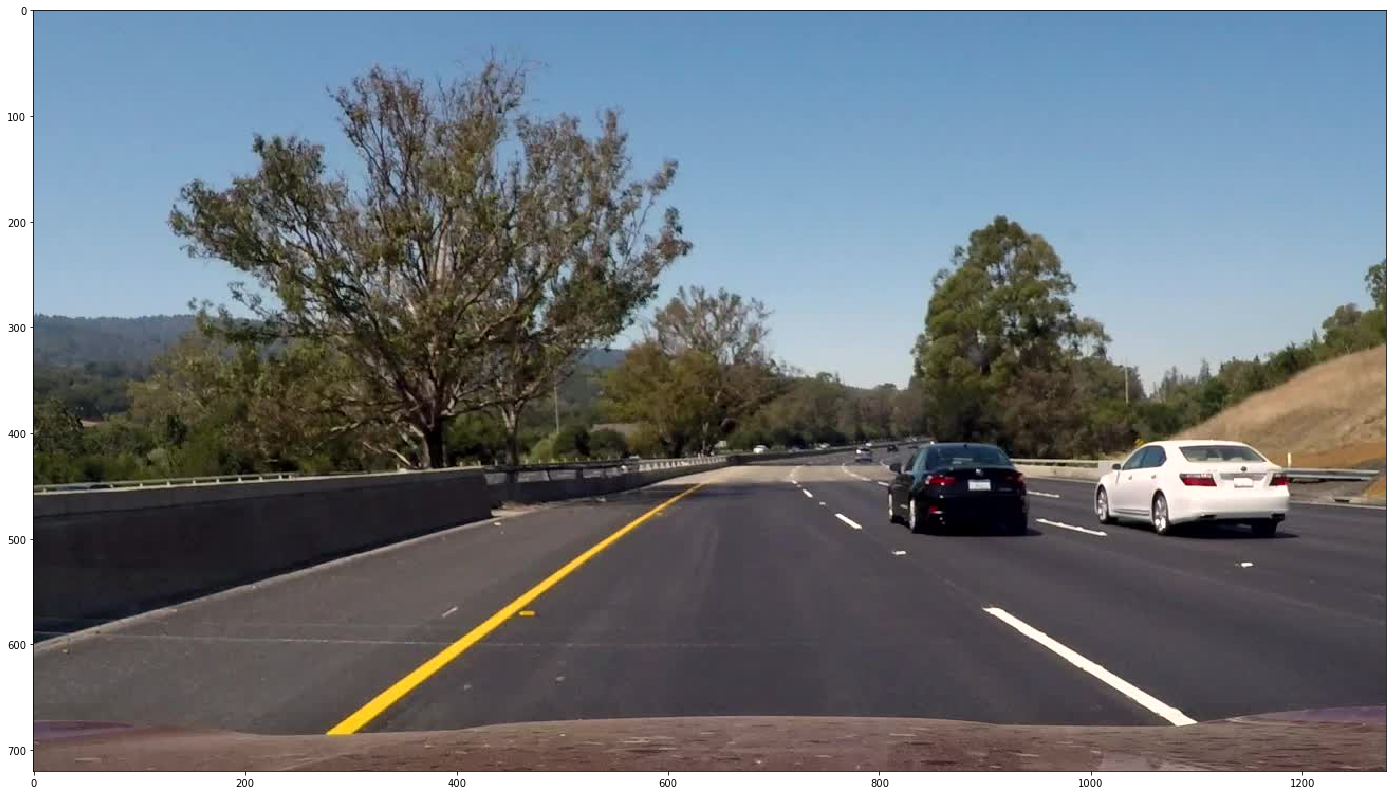

In [19]:
# Draw windows

img_copy = draw_boxes(img, selected_windows)
plt.figure(figsize=(25, 14))
plt.imshow(img_copy)

In [20]:
def dilate(img, times=3):
    for i in range(times):
        img = grey_dilation(img, size=(5,5))
    return img

Heat shape:  (720, 1280)


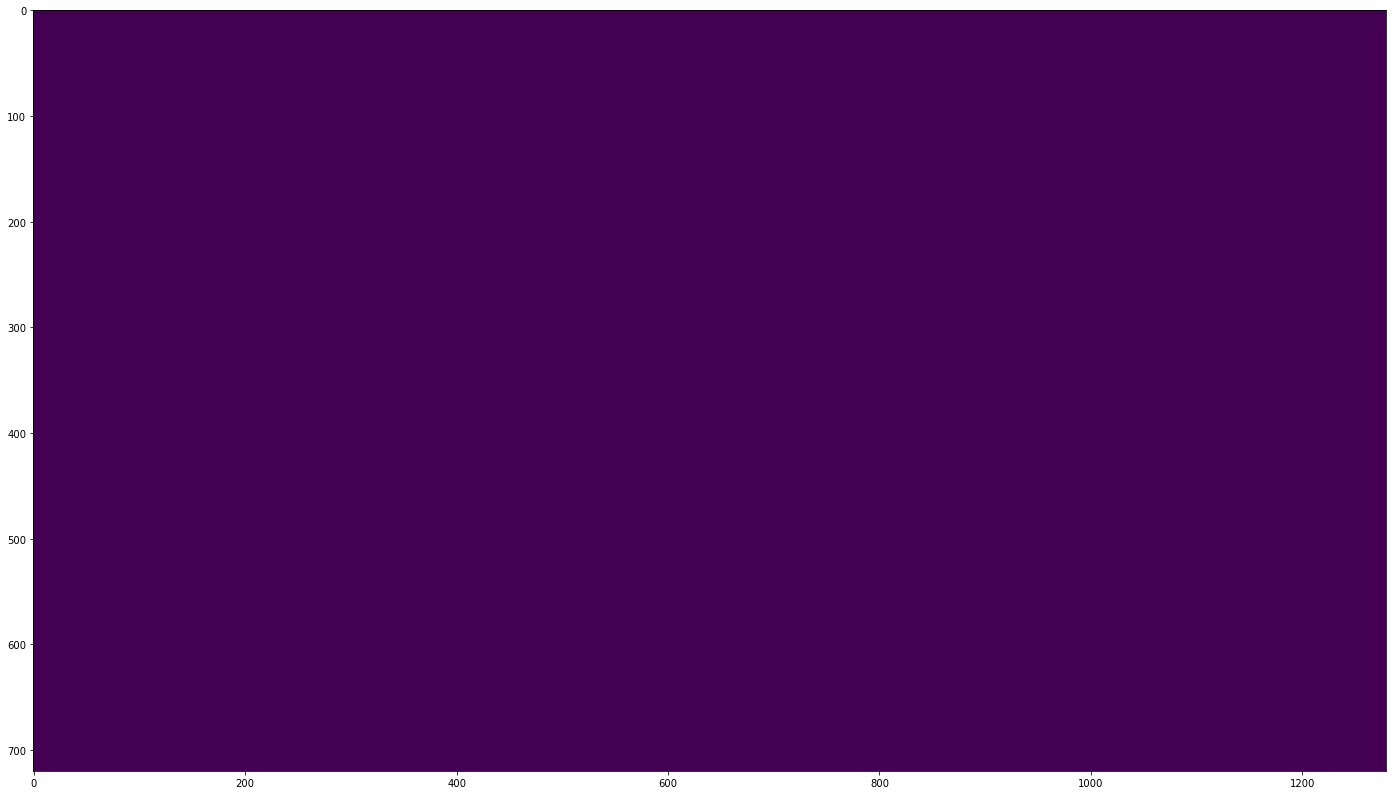

Heat shape:  (720, 1280)


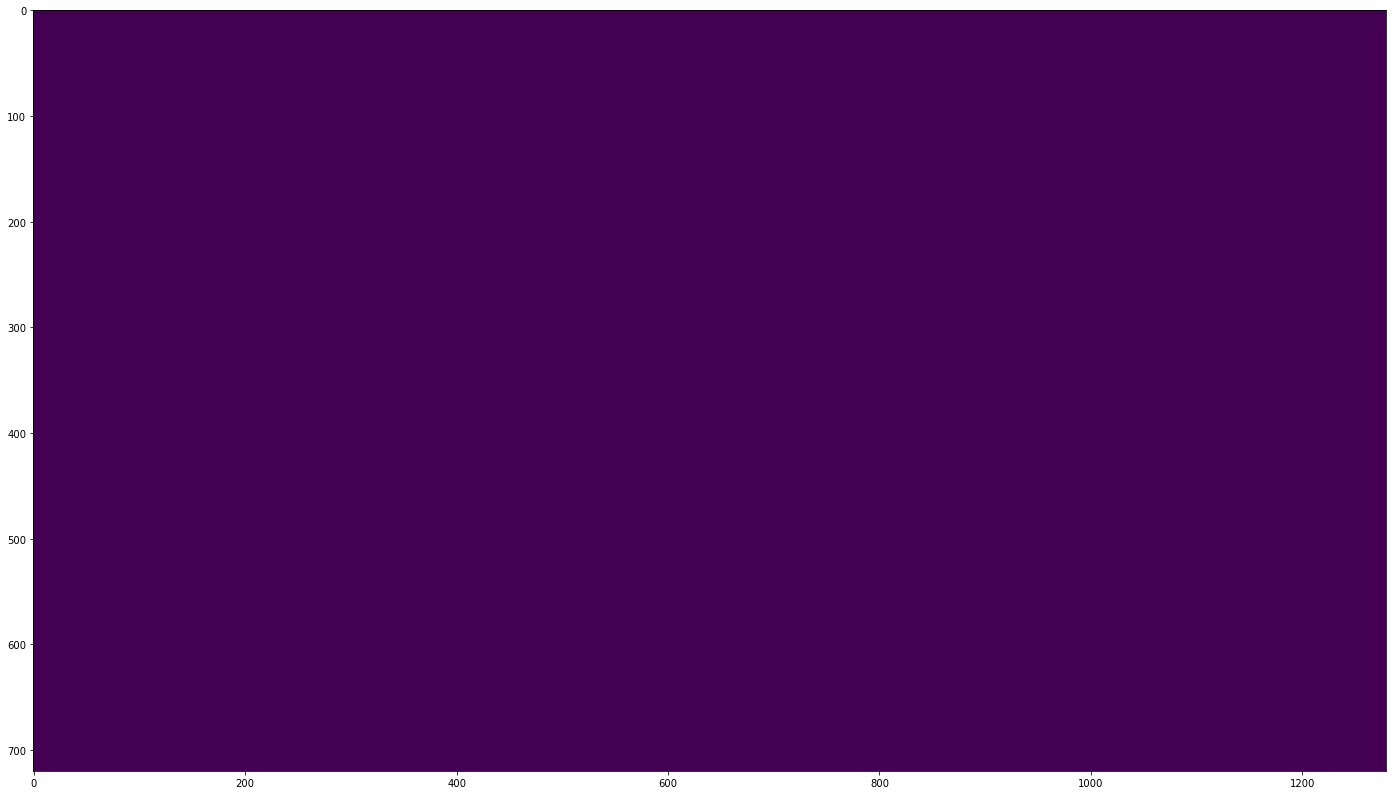

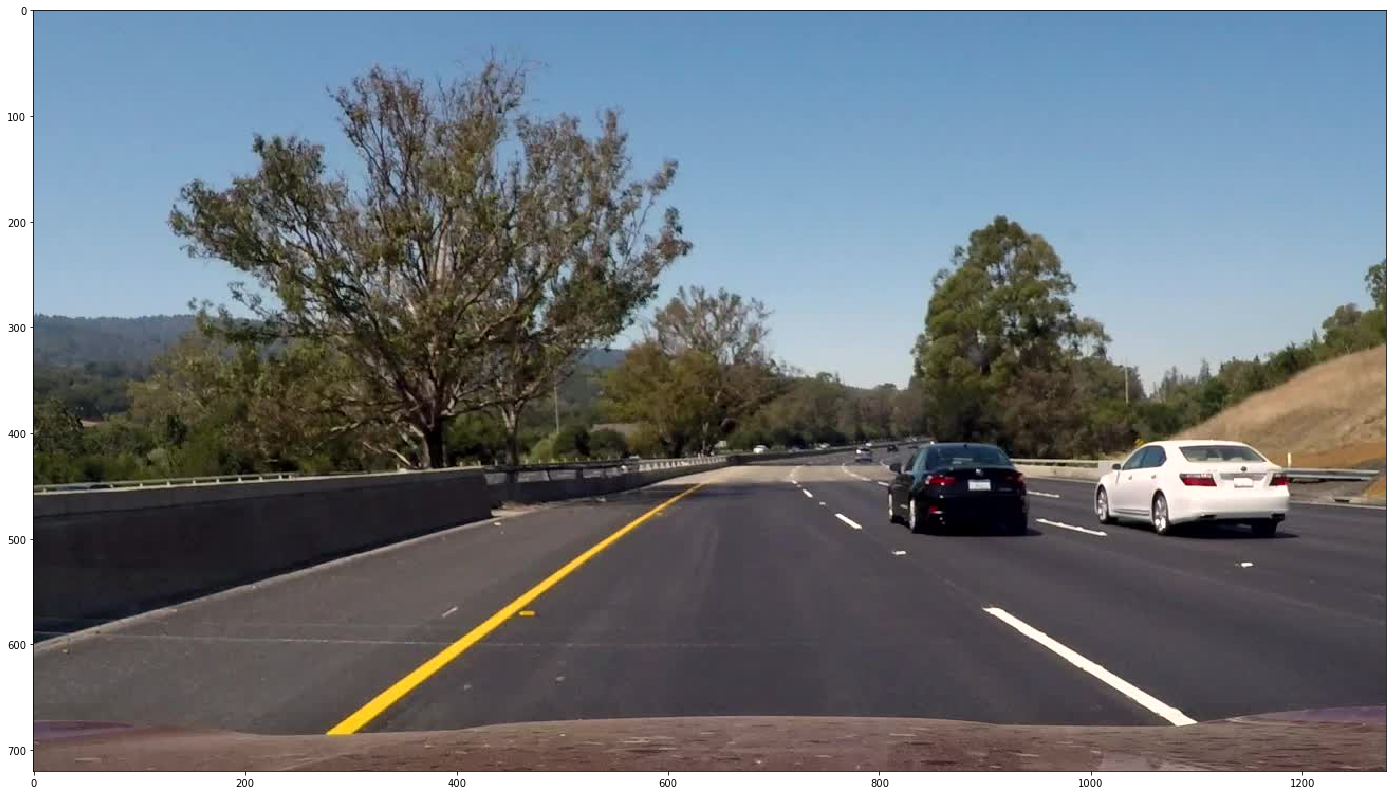

In [21]:
img_copy = img.copy()

heat = np.zeros_like(img_copy[:,:,0]).astype(np.float)

heat = add_heat(heat, selected_windows)

print("Heat shape: ", heat.shape)
plt.figure(figsize=(25,14))
plt.imshow(heat)
plt.show()

# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)
print("Heat shape: ", heat.shape)
plt.figure(figsize=(25,14))
plt.imshow(heat)
plt.show()
heat = dilate(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

structure = np.ones(9).reshape((3,3))
labels = label(heatmap, structure)
draw_img = draw_labeled_bboxes(img_copy, labels)

plt.figure(figsize=(25,14))
plt.imshow(draw_img)
plt.show()

Temp window size  7733
Temp window size  1632
Temp window size  235
Temp window size  0


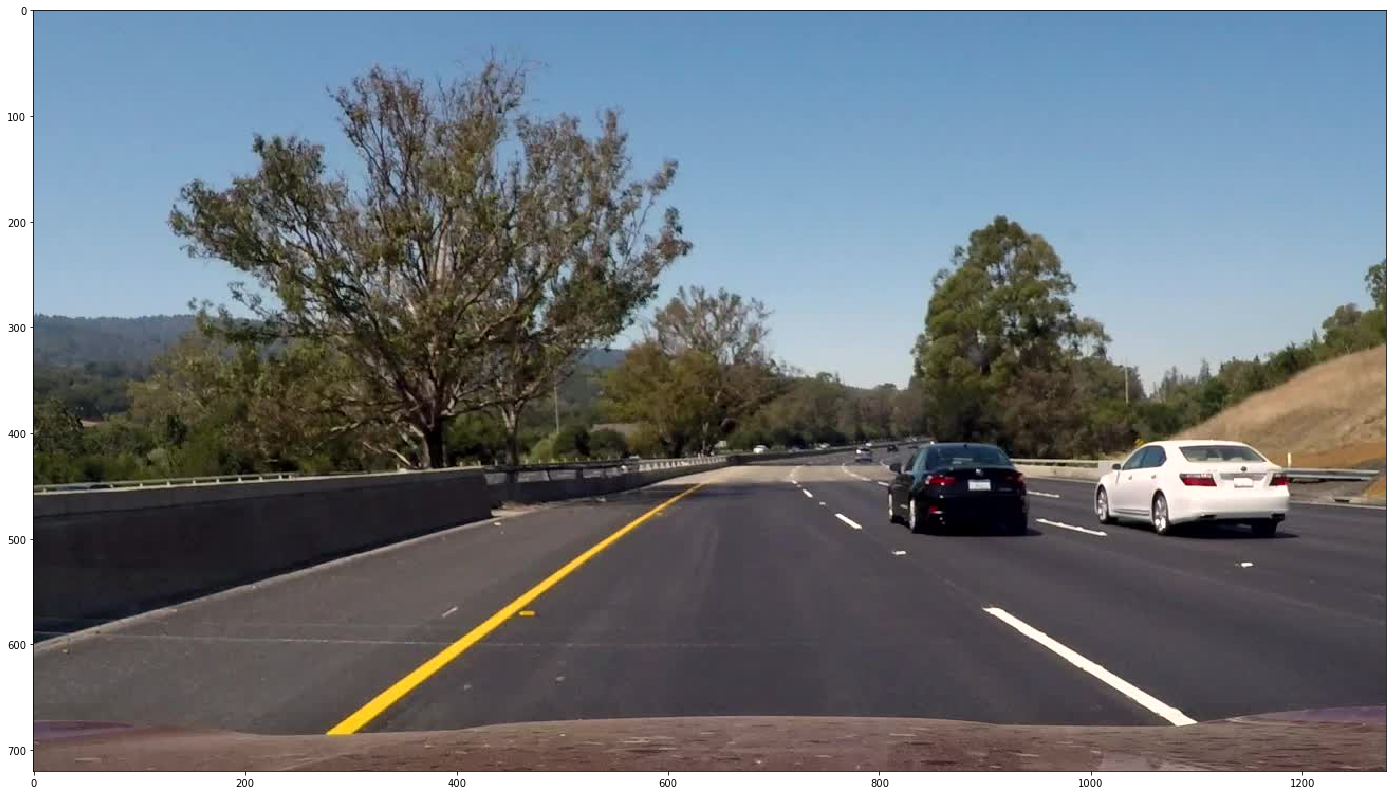

In [22]:
final_img = pipeline(img, clf, X_scaler, pca)

plt.figure(figsize=(25,14))
plt.imshow(final_img)

Temp window size  7733
Temp window size  1632
Temp window size  235
Temp window size  0


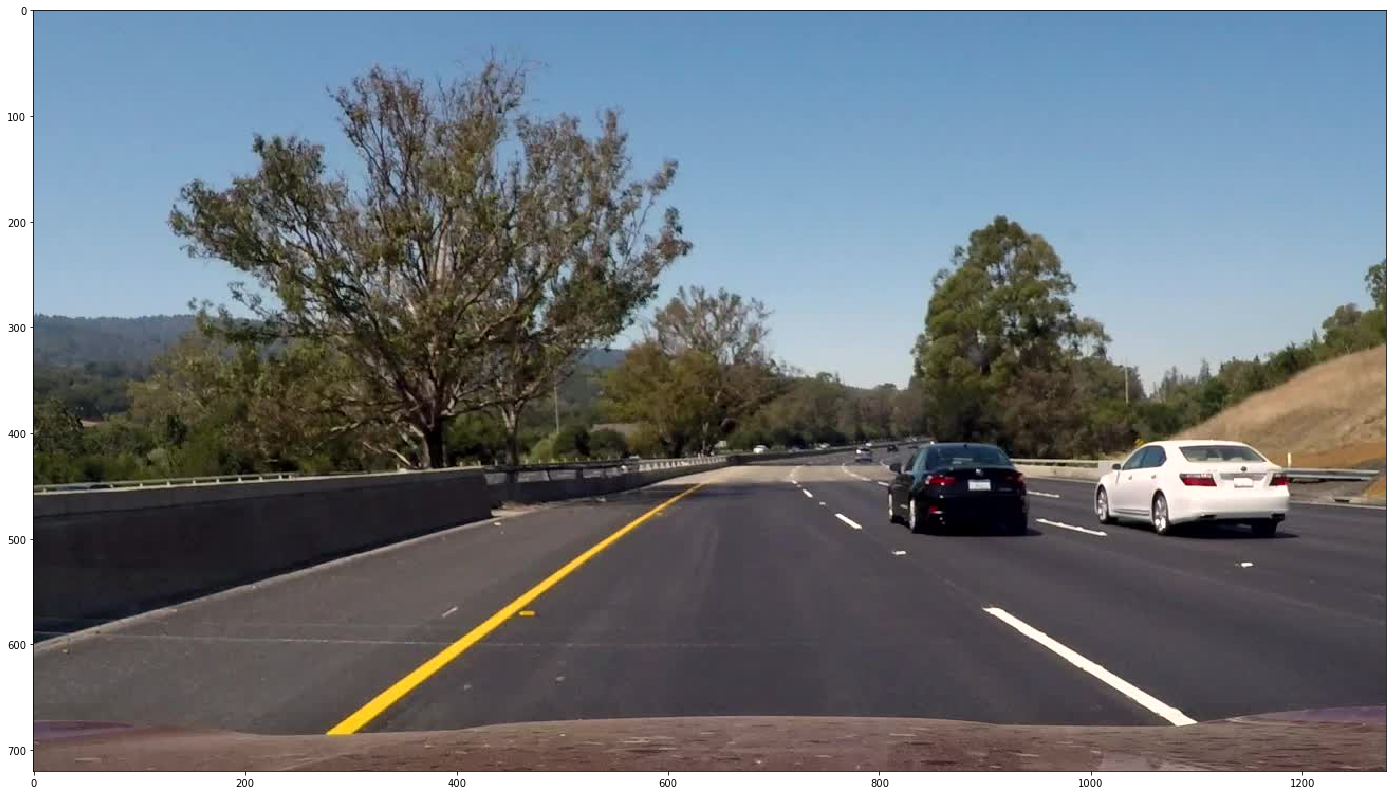

In [23]:
img=mpimg.imread('../test001.jpg')

final_img = pipeline(img, clf, X_scaler, pca)

plt.figure(figsize=(25,14))
plt.imshow(final_img)

import os

for img_file in os.listdir('../video_images'):
    img=mpimg.imread('../video_images/'+img_file)

    final_img = pipeline(img, clf, X_scaler, pca)

    plt.figure(figsize=(25,14))
    plt.imshow(final_img)
    io.imsave('../output_images/'+img_file, final_img)

In [24]:
#generate_video(clf, X_scaler, pca)